<img src="../../../common/logo_DH.svg" align='left' width=50%/>

### Clustering

Vamos a trabajar con un dataset de WORLD-HAPPINES


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score,calinski_harabasz_score,classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler

# para DBSCAN:
from scipy.spatial.distance import pdist,squareform

matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
data=pd.read_csv('2019.csv')
data.columns

Index(['Overall rank', 'Country or region', 'Score', 'GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption'],
      dtype='object')

In [3]:
data.describe()

,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,78.500000,5.407096,0.905147,1.208814,0.725244,0.392571,0.184846,0.110603
std,45.177428,1.113120,0.398389,0.299191,0.242124,0.143289,0.095254,0.094538
min,1.000000,2.853000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.750000,4.544500,0.602750,1.055750,0.547750,0.308000,0.108750,0.047000
50%,78.500000,5.379500,0.960000,1.271500,0.789000,0.417000,0.177500,0.085500
75%,117.250000,6.184500,1.232500,1.452500,0.881750,0.507250,0.248250,0.141250
max,156.000000,7.769000,1.684000,1.624000,1.141000,0.631000,0.566000,0.453000


In [4]:
# 2 etiquetas - Feliz / No Feliz
#data["Happy"] = data.Score.apply(lambda x: 1 if (x<5.4) else 0)

# 3 etiquetas - 'Poco Feliz', 'Feliz' y 'Muy Feliz'
ventana = (data.Score.max() - data.Score.min())/3
data["Happy"] = data.Score.apply(lambda x: 0 if (x<(data.Score.min()+ventana)) else (1 if (x<(data.Score.min()+2*ventana)) else 2))

# 4 etiquetas - 
#data["Happy"] = data.Score.apply(lambda x: 3 if (x<4.54) else (2 if (x<5.37) else (1 if (x<6.18) else 0)))

# ESTO LO HABÍA HECHO PREVIAMENTE, PERO LAS MEDIDAS silhouette y calinski-harabasz INDICARON 3 CLUSTERS

# ATENCIÓN: EN CADA MODELO VERIFICAR EL "NOMBRE" (ETIQUETA) QUE SE LE ASIGNA A CADA CLUSTER QUE SE ENCUENTRA 
# YA QUE HAY QUE HACER QUE SEAN CONSISTENTES CON LAS REALES ("y") PARA LOS classification_report y confusion_matrix.


In [5]:
data.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Happy
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,2
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,2
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,2
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,2
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,2


In [6]:
data.columns

Index(['Overall rank', 'Country or region', 'Score', 'GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Happy'],
      dtype='object')

In [7]:
X= data.drop(["Overall rank", "Country or region", "Score", "Happy"], axis=1)
y= data["Happy"]

print(X.shape)
print(y.shape)

(156, 6)
(156,)


### 1. Visualización

Exploración visual de los datos para ver si existe una estructura de clusters consistente con las categorías 'Poco Feliz', 'Feliz' y 'Muy Feliz'. 
Los datos tienen 7 dimensiones por lo que hacer un pairplot de todas contra todas es sencillo. 

Hay alguna combinación de features que separe visualmente las clases?




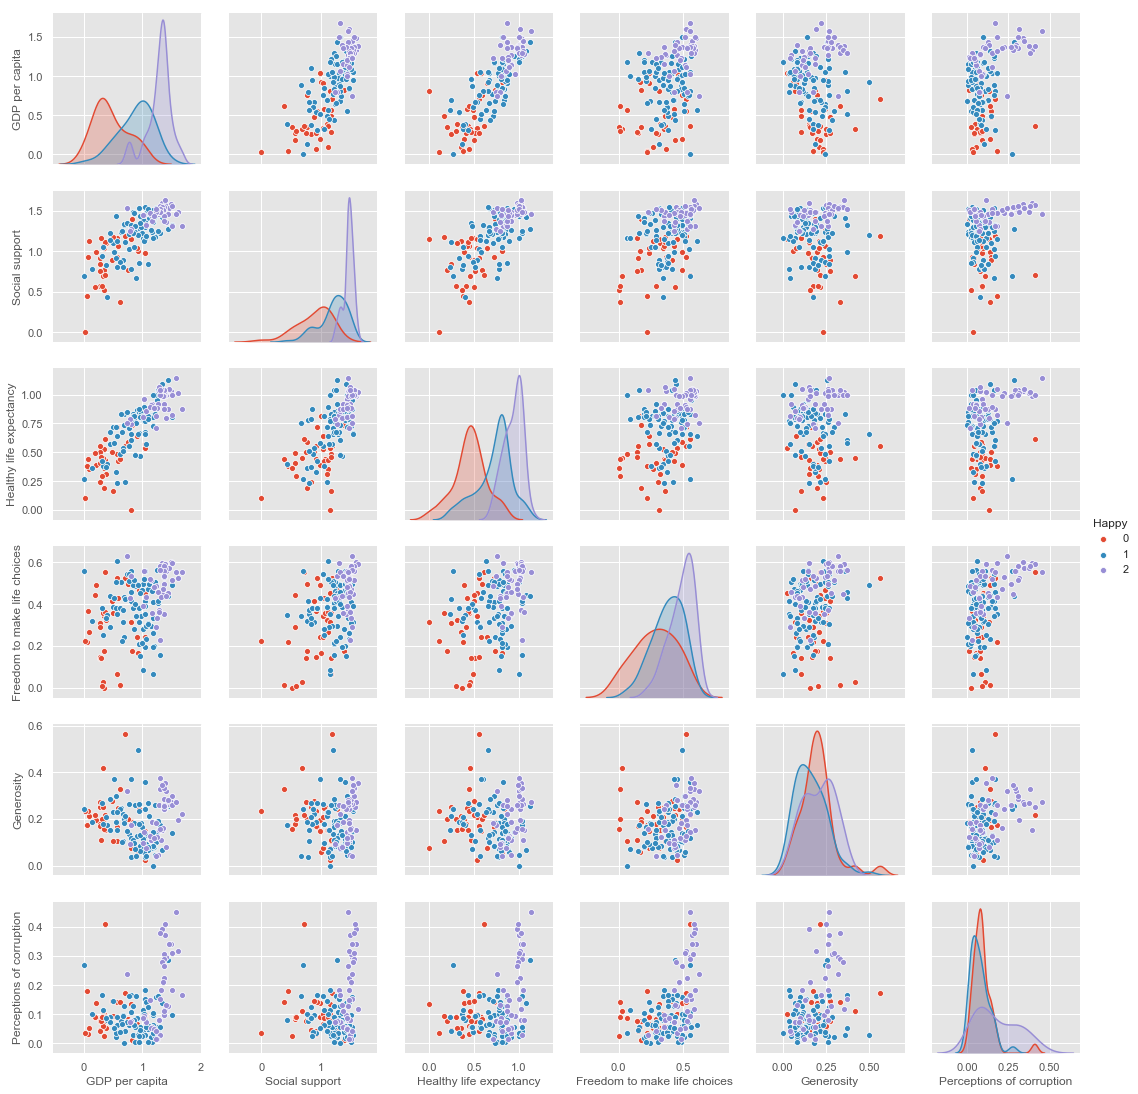

In [8]:
data_hue = pd.concat([X,y], axis=1)
sns.pairplot(data_hue, hue="Happy")

# PARECIERA QUE HAY 3 GRUPOS MEDIANAMENTE BIEN DEFINIDOS

# como se ve que la densidad de puntos en estas dimensiones estas variables no están tan bien distribuidos, 
# es decir, se ven zonificadas pero no hay "grupos".
# La sensidad de puntos es bastante pareja con lo cual probablemente con DB-SCAN no podría separarlas.

Vemos que típicamente ninguna columna separa completamente los datos, pero si parecen aportar para lograr una combinación predictora de la clase. 
A continuación, usaremos el scatterplot de 'GDP per capita' vs 'Social support' para evaluar visualmente los clusters que encontremos con diferentes algoritmos.

#### 2. Estandarización

Antes de implementar un algoritmo de clustering, qué hay que hacer con los datos? 


In [9]:
# Estandarizamos los datos
scaler=StandardScaler()
X_sc=scaler.fit_transform(X);

#### 3. Kmeans

Empezamos por usar Kmeans, variando k entre 2 y 9. Graficamos las medidas silhouette y calinski-harabasz en cada caso. 

¿Qué nos dicen sobre la estructura de los datos? 

silhouette: 

LO QUE MIDE ES LA RELACIÓN DE LA DITANCIA DE CADA PUNTO AL RESTO DE LOS PUNTOS DEL MISMO CLUSTER y COMPARA ESA DISTANCIA CON LAS DISTANCIAS A CLUSTERS CERCANOS.

SI LOS CLUSTERS ESTÁN BIEN DEFINIDOS y AISLADOS DE OTROS CLUSTERS -> LA MÉTRICA ES CERCANA A 1

SI LOS PUNTOS ESTÁN TODOS DISTRIBUIDOS HOMOGENEAMENTE, ES DECIR NO SE VEN CLAROS LOS CLUSTERS-> LA MÉTRICA ES CERCANA A 0

SI LOS PUNTOS ESTÁN ASIGNADOS A CLUSTERS A LOS QUE NO PERTENECEN, ESTÁ RE MAL -> LA MÉTRICA ES NEGATIVA (CERCANA A -1)

calinsky: 

SE BUSCA UN NRO ALTO DE ESTA MÉTRICA.

COMPARA LA DISPERCIÓN DE CADA CLUSTER CON LA DISPERCIÓN ENTRE CLUSTERS.

SE ESPERA QUE HAYA POCA DISPERSCÓN DENTRO DE UN MISMO CLUSTER. 

SE ESPERA QUE HAYA MUCHA DISPERCIÓN ENTRE CLUSTERS DIFERENTES.


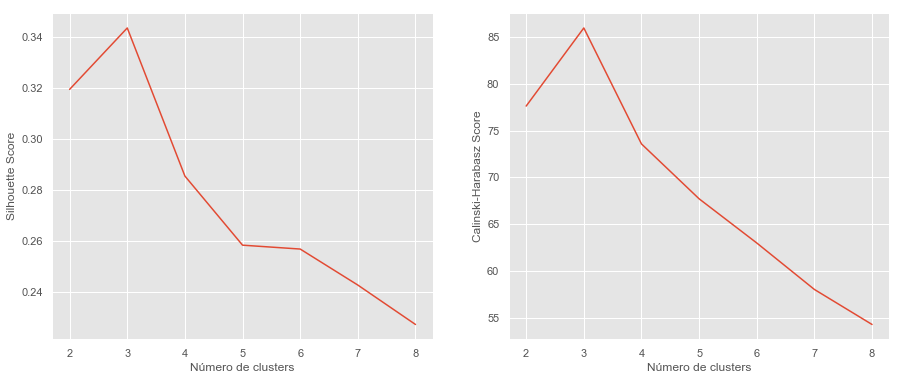

In [10]:
# PARECIERA QUE HAY 3 GRUPOS MEDIANAMENTE BIEN DEFINIDOS
# PERO VAMOS A HACER PRUEBAS CON DIFERNTES "k" UTILIZANDO VARIAS MÉTRICAS 
# BUSCANDO LOS k QUE MEJORAN DICHAS MÉTRICAS

evaluation = []
for k in range(2,9):
    kmeans = KMeans(n_clusters=k, random_state=0) 
    kmeans.fit(X_sc)
    labels = kmeans.labels_   # ETIQUETAS PREDICHAS (EN ESTE CASO SERÍA LOS CLUSTERS QUE ENCONTRÓ)
    centroids = kmeans.cluster_centers_ # CENTROIDES
    #predY = np.choose(labels, pd.Series(range(0,k+1)).astype(np.int64))
    silhouette = silhouette_score(X_sc, labels, metric='euclidean')
    calinsky = calinski_harabasz_score(X_sc, labels)      
    evaluation.append([k, silhouette, calinsky])  # ARMAMOS UN ARRAY
    #print("K= ", evaluation)

evaluation=np.array(evaluation);

f,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(evaluation[:,0],evaluation[:,1]) 
ax[0].set_ylabel('Silhouette Score')
ax[0].set_xlabel('Número de clusters')

ax[1].plot(evaluation[:,0],evaluation[:,2]) 
ax[1].set_ylabel('Calinski-Harabasz Score')    
ax[1].set_xlabel('Número de clusters');

# calinski_harabasz_score: vemos que es cercana a 0. Con lo cual habla de puntos con densidas homogenea.

# SE OBSERVA QUE LAS DOS MÉTRICAS DECRECEN A PARTIR DE 3 CLUSTERS, Y NUNCA SE VE UN PICO MEJOR, 
# CON LO CUAL 3 ES EL MEJOR k EN ESTE CASO.

####  Evaluación

Dado que conocemos las etiquetas, podemos testear el clustering viendo las métricas que vimos para clasificación.  

* Graficamos la matriz de confusión comparando las etiquetas reales con las predichas para el caso en que k=3.

* Usamos la herramienta classification_report de sklearn.metrics para evaluar el resultado mirando distintas métricas. 

¿Cuál es la métrica más importante en este caso? XXXXXXXXXXXXXXXXXX

* Graficamos en un scatterplot de 'GDP per capita' vs 'Social support' los clusters encontrados. Comparamos visualmente con el scatterplot del punto 1 en donde usamos las etiquetas reales.

In [11]:
# ESTOS VALORES DE INICIALIZACIÓN DE LOS "cluster_centers_" LOS OBTUVIMOS LUEGO DE HACER UNAS PASADAS CON KMEANS
# ES LA ÚNICA MANERA QUE ENCONTRAMOS PARA LOGRAR QUE LAS ETIQUETAS QUE KMEANS LE ASIGNA A LOS CLUSTER, 
# COINCIDAN CON LAS QUE YO TENGO ASIGNADAS EN "y" (0/1/2)
# (otra manera es renombras las etiquetas una vez asignadas, como vamos a hacer en el resto de nuestros modelos)
inicio =np.array([[-1.2737923 , -1.15083343, -1.25977929, -0.51571571,  0.2553247 , -0.10543818],
       [ 0.33840122,  0.34041826,  0.38387917, -0.07257391, -0.54376011, -0.43828352],
       [ 1.0440483 ,  0.84045675,  0.88671774,  1.04395863,  1.20151704, 1.46865179]])
inicio

array([[-1.2737923 , -1.15083343, -1.25977929, -0.51571571,  0.2553247 ,
        -0.10543818],
       [ 0.33840122,  0.34041826,  0.38387917, -0.07257391, -0.54376011,
        -0.43828352],
       [ 1.0440483 ,  0.84045675,  0.88671774,  1.04395863,  1.20151704,
         1.46865179]])

In [12]:
# KMeans:  INSTANCIAMOS y FITEAMOS
kmeans = KMeans(n_clusters=3, init=inicio)  # random_state=0
kmeans.fit(X_sc)
labels_km = kmeans.labels_

C:\Users\Emiliano\anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
kmeans.cluster_centers_

array([[-1.2737923 , -1.15083343, -1.25977929, -0.51571571,  0.2553247 ,
        -0.10543818],
       [ 0.33840122,  0.34041826,  0.38387917, -0.07257391, -0.54376011,
        -0.43828352],
       [ 1.0440483 ,  0.84045675,  0.88671774,  1.04395863,  1.20151704,
         1.46865179]])

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        35
           1       0.70      0.73      0.72        79
           2       0.82      0.55      0.66        42

    accuracy                           0.70       156
   macro avg       0.71      0.69      0.69       156
weighted avg       0.71      0.70      0.70       156



Text(0.5,1,'Kmeans')

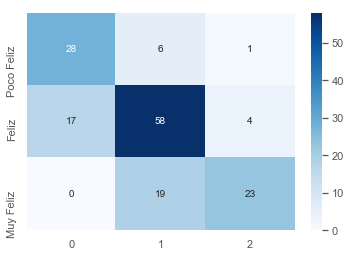

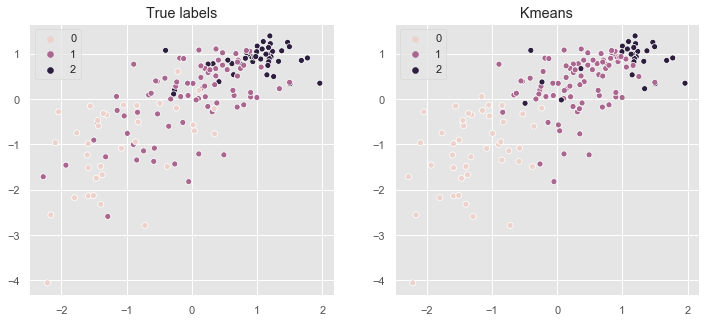

In [14]:
# AHORA VAMOS A COMPARAR LOS CLUSTERS QUE OBTIENE KMeans CONTRA LOS RESULTADOS REALES QUE TIENE EL DATASET.

# confusion_matrix:
sns.heatmap(confusion_matrix(y,labels_km),annot=True,cmap='Blues', fmt=".0f", yticklabels=['Poco Feliz', 'Feliz', 'Muy Feliz']);

# classification_report:
print(classification_report(y,labels_km))

# scatterplot de 'GDP per capita' vs 'Social support' - TRUE y PREDICHOS:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(X_sc[:,0],X_sc[:,1],hue=y.values,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(X_sc[:,0],X_sc[:,1],hue=labels_km,ax=ax[1])
ax[1].set_title('Kmeans')

# LA MATRIZ DE CONFUSIÓN DA BASTANTE DIAGONAL, ESO ES BUENO
# LA DISPERCIÓN DE LAS ETIQUETAS  contra LAS CORRECTAS 
# accuracy: 
# EN UN CASO DE DIAGNOSTICO QUEREMOS MINIMIZAR LOS Falsos Negativos (FN), POR ESO QUEREMOS VER EL recall (sensibilidad)
# sensibilidad: CUÁNTAS DE LAS ETIQUETAS QUE ERA MALIGNA FUE CORRECTAMENETE IDETIFICADA

# el RECALL vale para la clase 1 o clase 0.. sería pensar en 
# minimizar el porcentaje de FALSOS PREDICCIONES de cada CLASE

#### 4. Clustering Jerárquico

* Implementamos un modelo de clustering jerárquico usando el método 'ward' y graficamos el dendrograma. 
Se ve una estructura de 3 clusters.

* Seleccionamos 3 clusters con la función fcluster().

* Graficamos la matriz de confusión y el clasification_report para este caso. ¿Cómo performa en relación a kmeans?


Ukraine
Moldova
Bosnia and Herzegovina


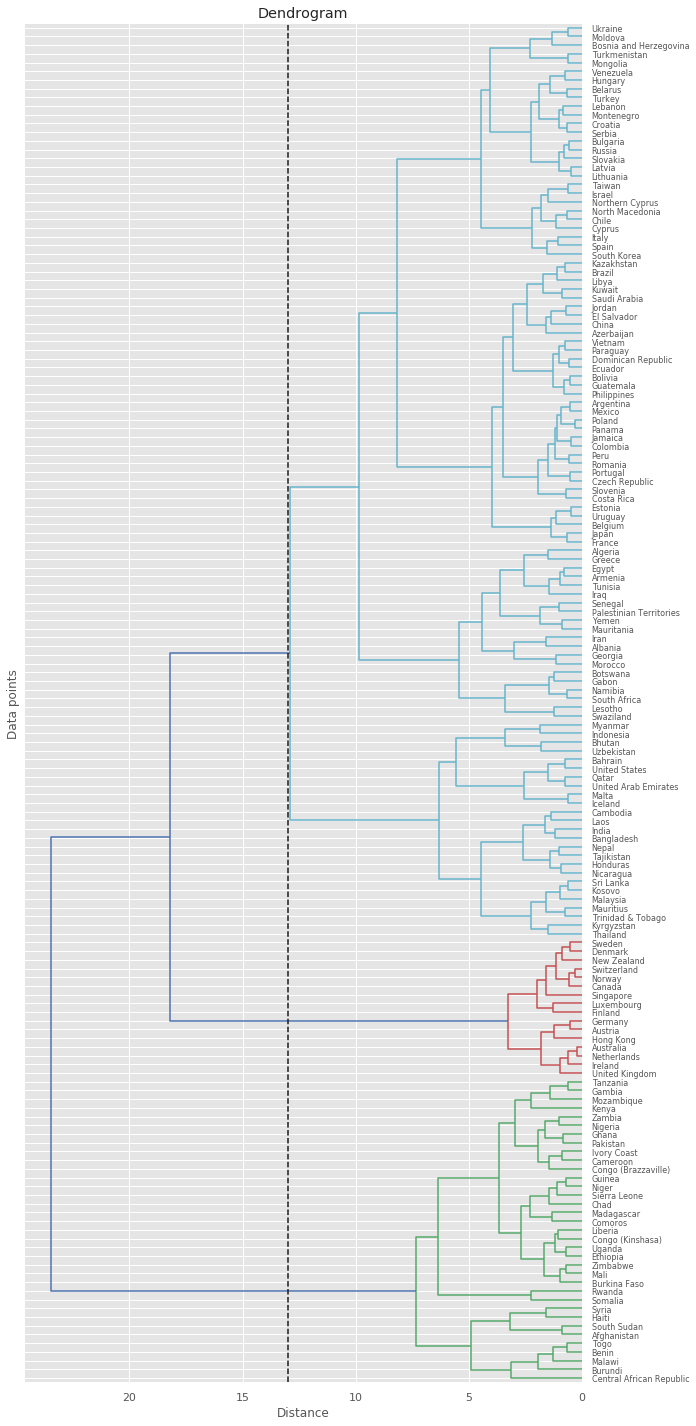

In [15]:
# linkage:  INSTANCIAMOS y CLUSTERIZAMOS JERÁQUICAMENTE EN z

# Acomodamos el tamaño de la figua para poder ver el arbol completo

from pylab import rcParams
rcParams['figure.figsize'] = 10, 25

# Luego de probar con los métodos disponibles = 'single' / 'average' / 'weighted'/ 'centroid' / 'median' / 'ward'
# agrupar con "WARD" se parece más a K-MEANS en cómo agrupa
# agrupar con "SINGLE" se parece más a DB-SCAN
# Hacemos el "Hierarchical Clustering" con el método 'Ward'

# PRIMERO USAMOS linkage  - 
# CONSULTAR SI HAY QUE UTILIZAR LOS DATOS ESTANDARIZADOS ????? - PORQUE CAMBIAS MUCHO EL AGRUPAMIENTO
# Si utilizo los datos Estandarizado se observan agurpaciones más separadas
z = linkage(X_sc, method='ward')
# Si utilizo los datos en "crudo" se agrupan más claramente en 3 Clusters
#z = linkage(X, method='ward')

# si no utlizamos "labels=names" en el Dendograma etiqueta con los índices de Dataframe
# esta línea la utilizamos para verificar que estamos asignando bien las etiquetas "Country or region"
print(data["Country or region"][132]) # "Ukraine"
print(data["Country or region"][70]) # "Moldova"
print(data["Country or region"][77]) # "Bosnia and Herzegovina"

# color_palette=['r','g','y','m','c'];
# hierarchy.set_link_color_palette(color_palette) 

limite = 13      # aquí definimos el threshold a partir del cual cambiar los colores por cluster

# Display dendrogram
names = data["Country or region"].values
info = dendrogram(z, labels=names, leaf_font_size=8, color_threshold=limite, orientation='left')

# Display dendrogram limite
plt.vlines(limite,0,X_sc.shape[0]*100,linestyle='--') 

plt.title('Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Data points')

# Reseteamos los parámetros de ploteo
rcParams.update(plt.rcParamsDefault)


#-------------------------------- UTILIZANDO X_sc (datos Estandarizados) -----------------------------------
# Para que nos queden 3 CLUSTERS, hay que subir el limite=13
# Los grupos quedan armados muy diferente vs. utilizando los datos Crudos. 
# Hay que comparar con el resto de los modelo

#-------------------------------- UTILIZANDO X (datos Sin Estandarizar) -----------------------------------
# SE OBSERVA QUE PARA ARMAR LOS TRES CLUSTERS PRINCIPALES, HAY QUE DAR UN SALTO BASTANTE GRANDE (COMPARATIVAMENTE),
# ESO HABLA DE QUE EFECTIVAMENTE HAY 3 CLUSTERS BIEN DEFINIDOS YA QUE LOS SEPARA UNA DISTANCIA "GRANDE"
# SETEANDO UN limite=3 (observar escala del gráfico) SE COLOREAN CLARAMENTE LOS 3 CLUSTERS.

In [16]:
# USANDO LA FUNCIÓN fcluster NOS PODEMOS QUEDAR CON ESOS CLUSTERS 
# LE PASAMOS "Z" EL OUPUT DE linkage

labels_hc=fcluster(z, 3, criterion='maxclust');     # LE DECIMOS QUE SON 3 CLUSTERS.

# fcluster DEVUELVE ETIQUETAS 1, 2, 3 PERO PARA PODER COMPRARALA CON LAS "TARGET" LAS RENOMBRAMOS
labels_hc = pd.Series(labels_hc).apply(lambda x: 0 if (x==1) else (1 if (x==3) else 2))

labels_hc

0      2
1      2
2      2
3      1
4      2
      ..
151    0
152    0
153    0
154    0
155    0
Length: 156, dtype: int64

              precision    recall  f1-score   support

           0       0.63      0.63      0.63        35
           1       0.62      0.82      0.71        79
           2       0.94      0.36      0.52        42

    accuracy                           0.65       156
   macro avg       0.73      0.60      0.62       156
weighted avg       0.71      0.65      0.64       156



Text(0.5,1,'Hierarchical Clustering')

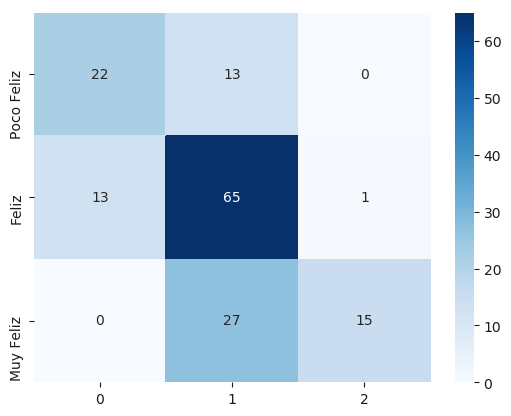

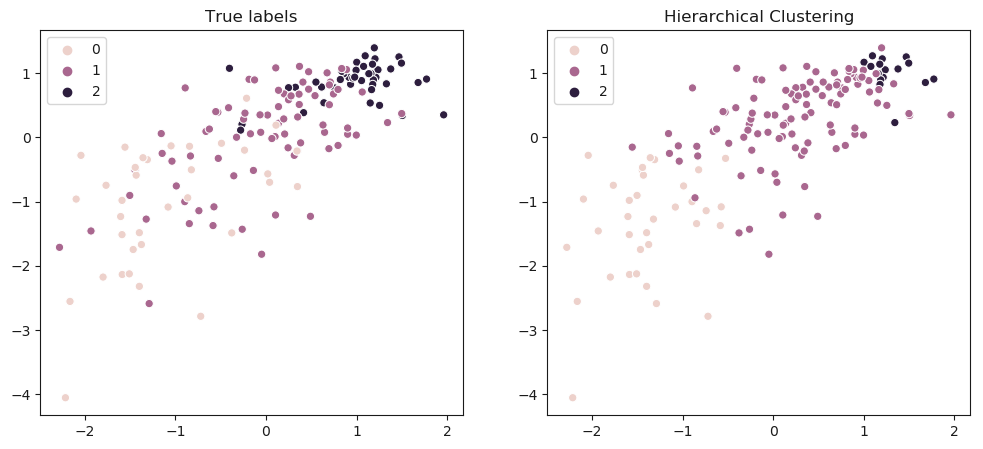

In [17]:
# AHORA VAMOS A COMPARAR LOS CLUSTERS QUE OBTIENE linkage CONTRA LOS RESULTADOS REALES QUE TIENE EL DATASET.

# confusion_matrix:
sns.heatmap(confusion_matrix(y,labels_hc), annot=True, cmap='Blues', fmt=".0f", yticklabels=['Poco Feliz', 'Feliz', 'Muy Feliz']);

# classification_report:
print(classification_report(y,labels_hc))

# scatterplot de 'GDP per capita' vs 'Social support' - TRUE y PREDICHOS:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(X_sc[:,0],X_sc[:,1],hue=y.values,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(X_sc[:,0],X_sc[:,1],hue=labels_hc,ax=ax[1])
ax[1].set_title('Hierarchical Clustering')


In [18]:
# SI VEMOS EL SCATTERPLOT SE VEN QUE HAY PUNTOS OSCUROS y CLAROS MEZCLADOS, PERO ESTO ES PORQUE EL CLUSTER TIENE 
# REALMENTE más DIMENSIONES Y AQUÍ SÓLO ESTAMOS VIENDO 2 DIMENSIONES
# PARA VERIFICARLO PODRÍAMOS IR ARRIBA Y HACER EL CLUSTERING USANDO SÓLO 2 DIMENIONES CORRIENDO LO SIGUIENTE:
# Z = linkage(X_sc[:,0:2] , 'ward');

#### 5. DBSCAN

Repetimos el análisis con DBSCAN. Para ello deberás seteamos los hiperparámetros minPts y eps. 


* Graficamos la curva de k-distancias para definir eps. TIP: se suele usar k=minPts-1. Miramos la curva para distintos valores de minPts razonables.

* Cuántos clusters encuentran con DBSCAN? Depende mucho del valor de los hiperparámetros?

* Graficamos los scatterplots correspondientes.


##### Dbscan (Density Based Spatial Clustering of Applications with Noise):

Es un algoritmo que, como su nombre lo indica, identifica clusters como regiones de alta densidad de puntos. El algoritmo tiene dos hiperparámetros: 

* Eps ($\epsilon$): un radio para definir la densidad local de cada punto

* minPts: número mínimo de puntos dentro del radio para considerar que un punto es de tipo <i>core</i>.

Se definen tres tipos de puntos:

* Core: puntos que tienen más de N vecinos dentro de un radio Eps. Es decir, son puntos de alta densidad.

* Border: puntos que están dentro del radio de un punto core, pero ellos no cumplen la condición de core. Son las fronteras de los clusters.

* Noise: puntos que no cumplen la condición de core ni de border. Son outliers, o ruido, y no pertenecen a ningún cluster.


#### El algoritmo se puede abstraer en estos tres pasos:


1) Etiquetar cada punto como core o non-core viendo si el número de vecinos en un radio Eps es mayor a minPts.
    
2) Encontrar las componentes conectadas por puntos core y asignarles un número de cluster a cada una.

3) Asignar el número del cluster más cercano a cada punto non-core, si se encuentra a una distancia menor a Eps. Si no, etiquetarlo como noise.

#### Entendiendo el método de selección de k y eps - UTILIZANDO k-distances:

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

We find a suitable value for epsilon by calculating the distance to the nearest n points for each point, sorting and plotting the results. Then we look to see where the change is most pronounced (think of the angle between your arm and forearm) and select that as epsilon.
The optimal value for epsilon will be found at the point of maximum curvature.
    

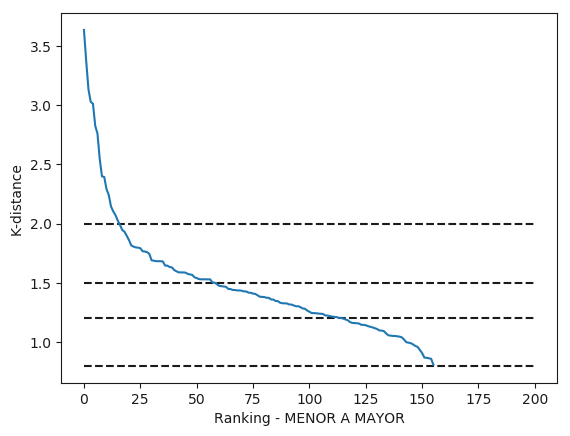

In [37]:
# UNA MANERA DE APROXIMARNOS A LOS VALORES DE LOS HIPERPARÁMETROS ES GRAFICAR LAS k-distancias.

minPts=10;  # ESTE VALOR LO PUSE BASTANTE AL AZAR

k=minPts-1;  # MÍNIMO DE PUNTOS menos 1 

D=squareform(pdist(X_sc));  # MEDIMOS LA DISTANCIA EUCLIDEA ENTRE LOS PARES DE PUNTOS, 
# PARA VERLA MEJOR USAMOS SQUAREFORM QUE DEVUELVE UNA MATRIZ CUADRADA CON LAS DISTANCIAS ENTRE PARES DE PUNTOS

k_distances=np.zeros(D.shape[0]);  #PARA VERLA MEJOR 

for i in range(D.shape[0]):           # RECORREMOS LAS FILAS DE LA MATRIZ DE DISTANCIAS
    distances=np.sort(D[i]);            # LAS ORDENAMOS LAS FILAS DE MENOR A MAYOR
    k_distances[i]=distances[k];        # NOS QUEDAMOS CON LAS DISTANCIAS AL K-esimo vecino mas cercano (k ES UN HIPERPARÁMETRO)
k_distances=np.sort(k_distances);     # LAS ORDENAMOS DECRECIENTEMENTE LAS DISTANCIAS A LOS kesimos VECINOS
k_distances=k_distances[::-1];          
    
plt.plot(k_distances);
plt.xlabel('Ranking - MENOR A MAYOR');
plt.ylabel('K-distance');
plt.hlines([2,1.5, 1.2, 0.8],0,200,linestyles='dashed');

# A PARTIR DEL CODO LA DISTANCIA AL Kesimo VECINO SE DISPARA, 
# CON LO CUAL PODEMOS INFERIR "EPSILON" DE ALGUNO DE LOS VALORES DE ESE CODO

In [22]:
D.shape

(156, 156)

              precision    recall  f1-score   support

           0       0.34      1.00      0.51        35
           1       0.71      0.37      0.48        79
           2       1.00      0.29      0.44        42

    accuracy                           0.49       156
   macro avg       0.68      0.55      0.48       156
weighted avg       0.70      0.49      0.48       156



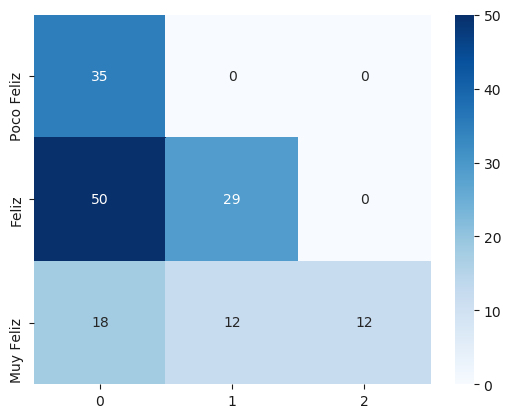

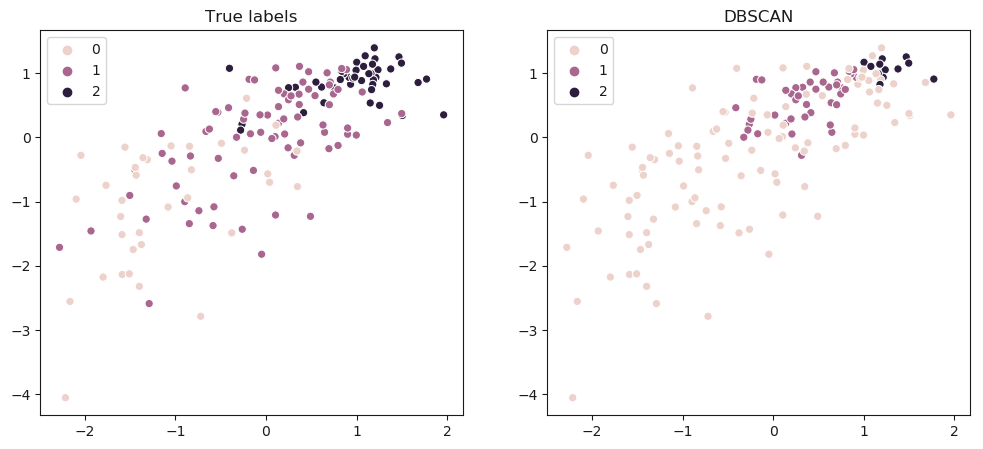

In [38]:
dbscan = DBSCAN(eps=1, min_samples=10)
labels_db = dbscan.fit_predict(X_sc)

# dbscan.fit_predict DEVUELVE ETIQUETAS -1, 0, 1 PERO PARA PODER COMPRARALA CON LAS "TARGET" LAS RENOMBRAMOS
labels_db  = pd.Series(labels_db).apply(lambda x: 0 if (x==-1) else (2 if (x==0) else 1))

# ARMAMOS OTRA VEZ: confusion_matrix / classification_report / distribución de los datos con scatterplots
sns.heatmap(confusion_matrix(y,labels_db), annot=True, cmap='Blues', fmt=".0f", yticklabels=['Poco Feliz', 'Feliz', 'Muy Feliz']);

print(classification_report(y,labels_db))

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(X_sc[:,0],X_sc[:,1],hue=y.values,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(X_sc[:,0],X_sc[:,1],hue=labels_db,ax=ax[1])
ax[1].set_title('DBSCAN');

# CON eps=1.2 y minPts=10 ENCUENTRA UN 3 CLUSTERS, pero no muy definidos
# CON eps=? y minPts=? ENCUENTRA UN?3 CLUSTERS, pero no muy definidos

# SE OBSERVAN 2 CODOS.. CONSULTAR

# POR LO TANTO DBSCAN NO ES BUENO PARA ESTE DATASET. 
# SE NOTA QUE NO HAY REGIONES DE BAJA DENSIDAD QUE SEPAREN LAS ZONAS DE ALTA DENSIDAD 
# Y POR LO TANTO EL ALGORITMO PUEDA UTILIZAR PARA CLUSTERIZAR BIEN

##### ---


<a id="section_referencias"></a> 
## Bonus Track

James, G.; Witten, D.; Hastie, T. & Tibshirani, R. (2013), An Introduction to Statistical Learning -- with Applications in R , Cap 10.3

Müller A.C., Guido S. (2016), Introduction to Machine Learning with Python, Cap 3

VanderPlas, J. (2016), Python data science handbook : essential tools for working with data, Cap 5 https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

https://developers.google.com/machine-learning/clustering/clustering-algorithms 